In [2]:
import torch
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import pydicom
from PIL import Image
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import scipy.io as sio
import random


#mat_file = sio.loadmat(r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF_TO_DICOM\labels_from_unet.mat")

# Read the labels from the mat file
#labels = mat_file['labels']

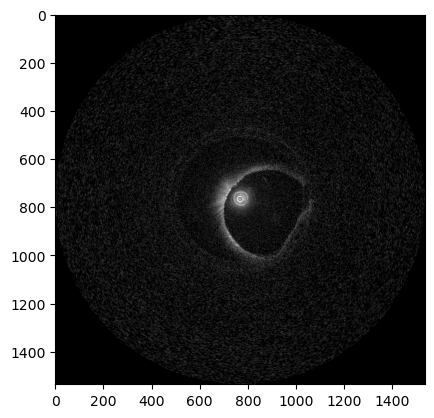

In [ ]:
tiff_folder_path = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF"
# Read all TIFF images from the folder into an array
images = []
for i, filename in enumerate(os.listdir(tiff_folder_path)):
    if i >= 10:
        break
    if filename.endswith('.tiff') or filename.endswith('.tif'):
        img_path = os.path.join(tiff_folder_path, filename)
        img = Image.open(img_path).convert('RGB')
        images.append((img))

# Show the first image in the array
plt.imshow(images[0])
plt.show()

# Noter 27/11
# tag en random 1/4 af billeder i data_gentuity -> train -> images ud og lave augmentering
# indlæs masker som json med data-loader-class og augmenter dem
# gem augmenteringer i aug_data_gentuity, i én samlet mappe, med unikt_id_4 og casenummer


In [ ]:
def augment_image(img_folder_path, labels_path):
    # Read all TIFF images from the folder into an array
    images = []
    for i, filename in enumerate(os.listdir(img_folder_path)):
        if i >= 10: ## Change this to the number of images to augment
            break
        if filename.endswith('.tiff') or filename.endswith('.tif'):
            img_path = os.path.join(img_folder_path, filename)
            # Take a random 1/4 of the images
            p = np.random.rand()
            if p > 0.25:
                continue
            img = Image.open(img_path)
            images.append(img)

    # Read labels from path
    labels_file = sio.loadmat(labels_path)
    labels = labels_file['labels']


    # Add images to a tensor and add a second channel dimension
    color_transform = v2.Compose([
        v2.ToTensor(),
        v2.ColorJitter(contrast=0.5, brightness=0.5, saturation=None, hue=None)
    ])

    class SynchronizedRandomRotation:
        def __init__(self, degrees):
            self.degrees = degrees

        def __call__(self, img, label):
            # Generate a random angle for rotation
            angle = v2.RandomRotation.get_params([-self.degrees, self.degrees])

            # Rotate both image and label by the same angle
            img = v2.functional.rotate(img, angle)
            label = v2.functional.rotate(label, angle)

            return img, label
        
    class SynchronizedCropping:
        def __init__(self, size):
            self.size = size

        def __call__(self, img, label):
            # Generate a center crop of the same size for both image and label
            img = v2.functional.center_crop(img, self.size)
            label = v2.functional.center_crop(label, self.size)

            # Resize the image and label to the original size
            img = v2.functional.resize(img, img.size)
            label = v2.functional.resize(label, label.size)

            return img, label
        
    # For each image in the tensor, apply the data augmentation
    augmented_images = []
    augmented_labels = []
    for i in range(len(images)):
        augmented_image = color_transform(images[i])

        augmented_image, augmented_label = SynchronizedRandomRotation(180)(augmented_image, labels[i])

        p = np.random.rand()
        if p < 0.25:
            augmented_image, augmented_label = SynchronizedCropping(np.random.randint(800, 1200))(augmented_image, augmented_label)
        augmented_images.append(augmented_image)
        augmented_labels.append(augmented_label)

    # Convert to  tensor
    augmented_images = torch.stack(augmented_images)
    augmented_labels = torch.stack(augmented_labels)

    return augmented_images, augmented_labels

def save_augmented_images(augmented_images, path):
    # Save the augmented images to a folder in a given path
    # Create the folder if it does not exist
    if not os.path.exists(path):
        os.makedirs(path)
    for i in range(augmented_images.shape[0]):
        img = augmented_images[i, 0, :, :]
        img = Image.fromarray(img.numpy())
        img.save(f"{path}/augment_image_{i}.tiff")

img_path = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF"
labels_path = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF_TO_DICOM\labels_from_unet.mat"

augmented_images, augmented_labels = augment_image(img_path, labels_path)

c:\Users\rasmu\anaconda3\envs\DL\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


TypeError: ToTensor.__init__() takes 1 positional argument but 2 were given

In [5]:
img_path = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF"
labels_path = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF_TO_DICOM\labels_from_unet.mat"

augmented_images, augmented_labels = augment_image(tiff_folder_path, labels_path)

# Plot the augmented images and labels side by side
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(augmented_images[0, 0, :, :], cmap='gray')
axs[0, 0].set_title('Augmented image 1')
axs[0, 1].imshow(augmented_labels[0, 0, :, :], cmap='gray')
axs[0, 1].set_title('Augmented label 1')
axs[1, 0].imshow(augmented_images[1, 0, :, :], cmap='gray')
axs[1, 0].set_title('Augmented image 2')
axs[1, 1].imshow(augmented_labels[1, 0, :, :], cmap='gray')
axs[1, 1].set_title('Augmented label 2')
plt.show()


#save_augmented_images(augmented_images, r"C:\Users\rasmu\OneDrive - Aarhus universitet\Bachelor\Andet\Videre arbejde\Data\Fantom 6 - Gentuity\TIFF_TO_DICOM\Augmented_images")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\rasmu\\OneDrive - Aarhus universitet\\Bachelor\\Andet\\Videre arbejde\\Data\\Fantom 6 - Gentuity\\TIFF\\Anonymous-Anonymous-Anonymous-20241031-105118_0044.tiff\\Anonymous-Anonymous-Anonymous-20241031-105118_0045.tiff'

**Testing**

In [ ]:
class RandomRotationWithLabel:
    def __init__(self, degrees, color_jitter_params=None):
        self.degrees = degrees
        self.rotation_transform = v2.RandomRotation(degrees)
        self.color_jitter = v2.ColorJitter(**color_jitter_params) if color_jitter_params else None

    def __call__(self, img, label):
        # Generate a random angle
        angle = v2.RandomRotation.get_params([-self.degrees, self.degrees])

        # Rotate image and label by the same angle
        img = v2.functional.rotate(img, angle)
        label = v2.functional.rotate(label, angle)

        # Apply ColorJitter only to the image
        if self.color_jitter:
            img = self.color_jitter(img)

        return img, label
    
# Example usage
transform = RandomRotationWithLabel(
    degrees=30,
    color_jitter_params={"brightness": 0.5, "contrast": 0.5, "saturation": 0.5, "hue": 0.2},
)

image = images_tensor[0]
label = labels[:,:,1]

# Apply the transformation
transformed_image, transformed_label = transform(image, label)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(transformed_image)
plt.title("Transformed Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_label)
plt.title("Transformed Label")
plt.axis("off")

plt.show()

In [ ]:
blur = v2.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))
blur_imgs = [blur(pil_image) for _ in range(4)]
#Plot original and equalized images
fig, ax = plt.subplots(1,5)
fig.set_size_inches(15, 5)
ax[0].imshow(tiff_images[1], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
for i, img in enumerate(blur_imgs):
    ax[i+1].imshow(np.array(img), cmap='gray')
    ax[i+1].axis('off')
plt.show()


In [ ]:
#Read tif img from path
img_path = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Dokumenter\Biomedicinsk teknologi\2. semester\Deep Learning\Gentuity6_test.tiff"
#img = Image.open(img_path)
img = images[1]

cropped = v2.CenterCrop(size=800)(img)
cropped = v2.Resize(size=img.size)(cropped)
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(cropped, cmap='gray')
plt.show()

In [ ]:
test_img = images[1]
test_label = Image.fromarray(labels[:,:,1])

class SynchronizedCropping:
    def __init__(self, size):
        self.size = size

    def __call__(self, img, label):
        # Generate a center crop of the same size for both image and label
        img = v2.functional.center_crop(img, self.size)
        label = v2.functional.center_crop(label, self.size)

        # Resize the image and label to the original size
        img = v2.functional.resize(img, img.size)
        label = v2.functional.resize(label, label.size)

        return img, label

# Example usage
transform = SynchronizedCropping(size=np.random.randint(800, 1200))


# Apply the synchronized rotation
transformed_image, transformed_label = transform(test_img, test_label)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(transformed_image)
plt.title("Crop and resize Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed_label)
plt.title("Crop and resize Label")
plt.axis("off")

plt.show()